# Importe de Librerias

In [89]:
import numpy as np 
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold,RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report , f1_score, recall_score, precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer,f1_score
from sklearn.ensemble import VotingClassifier


# Ensambles de modelos

## Preparamos los datasets para trabajar

In [32]:
ds_train = pd.read_csv('properati_argentina_train.csv')
ds_test = pd.read_csv('properati_argentina_test.csv')

In [33]:
ds_train.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,CLj2GNCsBreAzTKFXCaLIQ==,-34.601807,-58.469965,Departamento,2.0,1.0,53.0,49.0,80000.0,bajo
1,1,TvqKIPzzT1urYfVhh8tC7w==,-34.580088,-58.424965,Departamento,2.0,1.0,35.0,35.0,79900.0,medio
2,2,QRs3RUjw1RS5/WRne8ApbA==,-34.551481,-58.452358,Departamento,1.0,1.0,25.0,20.0,69000.0,medio
3,3,ju90QBsV36i7DCOOWCJpaA==,-34.632290,-58.464844,Departamento,5.0,3.0,75.0,75.0,150000.0,medio
4,4,uxD4SK3jtGbmxfIlN03UMQ==,-34.549279,-58.463074,Departamento,2.0,1.0,46.0,34.0,85000.0,bajo


In [34]:
ds_test.head()

,Unnamed: 0,id,latitud,longitud,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,precioxm2_relativo_q
0,0,1MIZ1gFNRkTXELdcBl+opQ==,-34.598679,-58.499717,Departamento,1.0,1.0,38.0,28.0,85000.0,medio
1,1,hi5vMb1IpzsBoUGGVGPCXA==,-34.574987,-58.420611,Departamento,2.0,1.0,150.0,70.0,520000.0,alto
2,2,f57uQb0jzaTRg98/B71HOg==,-34.586527,-58.398279,Departamento,2.0,1.0,43.0,41.0,87000.0,medio
3,3,gsO2peJbSoSQ0hI1E5TH8g==,-34.577647,-58.406064,Departamento,4.0,3.0,130.0,118.0,690000.0,alto
4,4,4cnMe44uQLFiAnBC1SXjUg==,-34.560998,-58.464248,Departamento,1.0,1.0,33.0,29.0,95000.0,alto


Elimino columnas 

- id no aporta nada en esta seccion del TP
- Unnamed: 0 

In [35]:
columnas_a_eliminar = ["id", "Unnamed: 0"]

ds_train.drop(columns = columnas_a_eliminar, inplace=True)
ds_test.drop(columns = columnas_a_eliminar, inplace=True)

#cambio nombre a precioxm2_relativo_q
ds_train.rename(columns={"precioxm2_relativo_q":"tipo_precio"}, inplace=True)
ds_test.rename(columns={"precioxm2_relativo_q":"tipo_precio"}, inplace=True)

#### Ingenieria de caracteristicas

Realizo dummies a la variable prperty_type

In [36]:
ds_train = pd.get_dummies(ds_train, columns=["property_type"], drop_first=True)
ds_test =  pd.get_dummies(ds_test, columns=["property_type"], drop_first=True)

Normalizo valores variables cantitativas

In [37]:
columnas_elegidas = ['property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered"]
sc = StandardScaler()

#estandarizo variables cuantitativas en train
x = ds_train.loc[:, columnas_elegidas].values
x = sc.fit_transform(x)
ds_train[columnas_elegidas] = x 

#estandarizo variables cuantitativas en test
y = ds_test.loc[:, columnas_elegidas].values
y = sc.transform(y)
ds_test[columnas_elegidas] = y


In [38]:
ds_train.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-34.601807,-58.469965,-0.572024,-0.901181,-0.360814,-0.422360,80000.0,bajo,1,0
1,-34.580088,-58.424965,-0.572024,-0.901181,-0.611332,-0.761908,79900.0,medio,1,0
2,-34.551481,-58.452358,-1.448310,-0.901181,-0.750509,-1.125710,69000.0,medio,1,0
3,-34.632290,-58.464844,2.056835,1.409468,-0.054625,0.208230,150000.0,medio,1,0
4,-34.549279,-58.463074,-0.572024,-0.901181,-0.458238,-0.786162,85000.0,bajo,1,0


In [39]:
ds_test.head()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,tipo_precio,property_type_Departamento,property_type_PH
0,-34.598679,-58.499717,-1.448310,-0.901181,-0.569579,-0.931682,85000.0,medio,1,0
1,-34.574987,-58.420611,-0.572024,-0.901181,0.989200,0.086963,520000.0,alto,1,0
2,-34.586527,-58.398279,-0.572024,-0.901181,-0.499991,-0.616388,87000.0,medio,1,0
3,-34.577647,-58.406064,1.180548,1.409468,0.710847,1.251129,690000.0,alto,1,0
4,-34.560998,-58.464248,-1.448310,-0.901181,-0.639168,-0.907429,95000.0,alto,1,0


## Voting

### Arbol de decision

In [40]:
features = ["latitud", "longitud", 'property_rooms', 'property_bedrooms', 'property_surface_total', "property_surface_covered", "property_type_Departamento", "property_type_PH"]

target = ["tipo_precio"]

In [41]:
#train
x_train =ds_train[features]
y_train = ds_train[target]

#test
x_test= ds_test[features]
y_test= ds_test[target]

#### Optimizacion de Hiperparametros

In [49]:
def optimizar_parametros(ds_train_x, ds_train_y):
    #Cantidad de combinaciones que quiero porbar
    n=20 

    #Conjunto de parámetros que quiero usar
    params_grid = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}
                    
    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree = DecisionTreeClassifier() 

    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    #Random Search Cross Validation
    randomcv = RandomizedSearchCV(estimator=base_tree,
                                param_distributions = params_grid,
                                scoring=scorer_fn,
                                cv=kfoldcv,
                                n_iter=n,
                                random_state=1) 


    return randomcv.fit(ds_train_x,ds_train_y)

randomcv_normal = optimizar_parametros(x_train, y_train)

In [50]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_normal.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_normal.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5752514796564024


In [66]:
best_tree = randomcv_normal.best_estimator_

### Random Forest

#### Optimizacon de parametros

In [52]:
def optimizar_parametros_rf(ds_train_x, ds_train_y):
    
    #Cantidad de combinaciones que quiero porbar
    n=20


    param_grid_rf = {'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,10)),
                'min_samples_split': list(range(12,20)),
                'ccp_alpha':np.linspace(0.001,0.005,n), 
                'max_depth':list(range(2,10))}

    #Cantidad de splits para el Cross Validation
    folds=10

    #Kfold estratificado
    kfoldcv = StratifiedKFold(n_splits=folds)

    #Clasificador
    base_tree_rf = RandomForestClassifier()#n_estimators=648


    #Metrica que quiero optimizar F1 Score
    scorer_fn = make_scorer(f1_score, average='micro')

    randomcv_rf = RandomizedSearchCV(   estimator=base_tree_rf,
                                        param_distributions = param_grid_rf,
                                        cv=kfoldcv,
                                        scoring = scorer_fn,
                                        n_jobs=-1,
                                        random_state=1)

    return randomcv_rf.fit(ds_train_x, ds_train_y)



randomcv_rf_normal = optimizar_parametros_rf(x_train, y_train)

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [53]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randomcv_rf_normal.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randomcv_rf_normal.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'min_samples_split': 17, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy', 'ccp_alpha': 0.002263157894736842}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.5669734538839502


In [54]:
best_rand_forest = randomcv_rf_normal.best_estimator_

### Knn

#### Optimizacion de parametros

In [60]:
def optimizar_parametros_knn(ds_train_x, ds_train_y): 

    #Grilla de Parámetros
    params_grid={ 'n_neighbors':range(10,30), 
                'weights':['distance','uniform'],
                'algorithm':['ball_tree', 'kd_tree', 'brute'],
                'metric':['euclidean','manhattan','chebyshev']
                }

    scorer_fn = make_scorer(f1_score, average='micro')

    #Clasificador KNN
    knn = KNeighborsClassifier()

    #Random Search con 10 Folds y 10 iteraciones
    rand = RandomizedSearchCV(knn, params_grid, scoring=scorer_fn, cv=10, n_iter=10, random_state=1)

    return rand.fit(ds_train_x, ds_train_y)

randcv_knn = optimizar_parametros_knn(x_train, y_train)


c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was 

In [61]:
#Mejores hiperparametros del arbol
print("Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: " + str(randcv_knn.best_params_))
#Mejor métrica
print("Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: " + str(randcv_knn.best_score_))

Para el dataset completo, obtuvimos que los mejores hiperparametros del arbol son: {'weights': 'distance', 'n_neighbors': 29, 'metric': 'manhattan', 'algorithm': 'brute'}
Y el f1-score que obtuvimos en el dataset completo para los datos de entrenamiento fue de: 0.6944215292378999


In [63]:
best_knn = KNeighborsClassifier().set_params(**randcv_knn.best_params_)

### Ensamblamos los modelos

In [69]:
#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('arbol', best_tree), ('rand_forest', best_rand_forest), ('knn', best_knn)], voting = 'hard')

#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)

c:\Users\Equipo de fabrica\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6244929155153154

#### Evaluo

In [79]:
def evaluar_modelo(ds_test_x, ds_test_y, knn):

    y_pred=knn.predict(ds_test_x)

    print('F1-Score: {}'.format(f1_score(ds_test_y, y_pred, average='micro'))) #binary considera la clase positiva por defecto 1
    #Reporte de Clasificación
    print(classification_report(ds_test_y,y_pred))

    #Matriz de Confusión
    cm = confusion_matrix(ds_test_y, y_pred)
    sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')

F1-Score: 0.6244929155153154
              precision    recall  f1-score   support

        alto       0.67      0.42      0.52      4252
        bajo       0.74      0.36      0.49      4265
       medio       0.60      0.86      0.70      8492

    accuracy                           0.62     17009
   macro avg       0.67      0.55      0.57     17009
weighted avg       0.65      0.62      0.60     17009



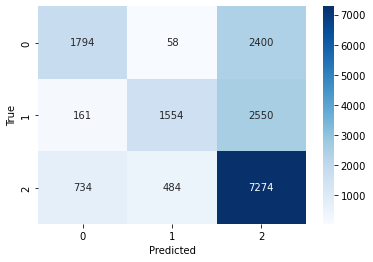

In [83]:
evaluar_modelo( x_test, y_test, vot_clf)

In [96]:
acc = accuracy_score(y_test, pred)
pre = precision_score(y_test, pred, average="macro")
rec = recall_score(y_test, pred, average="macro")
f1 = f1_score(y_test, pred, average='macro')

print("La metrica Accuracy con datos de testeo fue de: " + str(acc))
print("La metrica Precision con datos de testeo fue de: " + str(pre))
print("La metrica Recall con datos de testeo fue de: " + str(rec))
print("La metrica F1 con datos de testeo fue de: " + str(f1))

La metrica Accuracy con datos de testeo fue de: 0.6244929155153154
La metrica Precision con datos de testeo fue de: 0.6678778760699077
La metrica Recall con datos de testeo fue de: 0.5476170218971775
La metrica F1 con datos de testeo fue de: 0.569263313623512
